# Challenge Telecom X: análise de evasão de clientes - Parte 2

Esse projeto faz parte da trilha: Estatística e Machine Learning G8 - ONE

## 1. Extração do Arquivo Tratado

Nesta etapa, carregamos o arquivo CSV resultante da **Parte 1 do Desafio Telecom X**.
Esse arquivo já passou por limpeza e padronização, contendo apenas as colunas relevantes
para a modelagem preditiva.

O carregamento é feito com a biblioteca `pandas` e o arquivo `dataframe.csv`
foi previamente enviado ao ambiente do Google Colab.

Após a leitura, visualizamos as primeiras linhas para confirmar a estrutura e integridade.

In [1]:
# Manipulação e análise de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e modelagem
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# Métricas
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, precision_recall_curve, f1_score, accuracy_score
)

# Utilidades
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Carregando o dataset tratado (Parte 1)
df = pd.read_csv("/content/dataframe.csv")

# Visualizando as primeiras linhas
df.head()

,customer_id,Churn,gender,is_senior,Partner,Dependents,tenure,phone_service,multiple_lines,internet_service,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,charges_monthly,charges_total,daily_charges
0,0002-ORFBO,0.0,female,0,1,1,9,1,no,dsl,...,no,yes,yes,no,one year,1,mailed check,65.6,593.30,2.186667
1,0003-MKNFE,0.0,male,0,0,0,9,1,yes,dsl,...,no,no,no,yes,month-to-month,0,mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,1.0,male,0,0,0,4,1,no,fiber optic,...,yes,no,no,no,month-to-month,1,electronic check,73.9,280.85,2.463333
3,0011-IGKFF,1.0,male,1,1,0,13,1,no,fiber optic,...,yes,no,yes,yes,month-to-month,1,electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,1.0,female,1,1,0,3,1,no,fiber optic,...,no,yes,yes,no,month-to-month,1,mailed check,83.9,267.40,2.796667


## 2. Análise Descritiva Inicial

Antes de remover colunas irrelevantes, realizamos uma análise descritiva do `DataFrame` para entender:

- Quantidade de linhas e colunas.
- Tipos de variáveis (numéricas e categóricas).
- Presença de valores ausentes e duplicados.
- Distribuição da variável alvo (`Churn`).

Essa etapa é essencial para embasar decisões de pré-processamento, como remoção de colunas, imputação de valores e definição de estratégias de modelagem.


In [3]:
# Dimensão do dataset
print(f"Formato: {df.shape[0]} linhas e {df.shape[1]} colunas")

# Tipos de dados
print("\nTipos de dados:")
print(df.dtypes)

# Estatísticas gerais
print("\nResumo estatístico:")
print(df.describe().T)

# Valores ausentes
print("\nValores ausentes por coluna:")
print(df.isnull().sum())

# Valores duplicados
print(f"\nDuplicatas: {df.duplicated().sum()} linhas duplicadas")

# Distribuição da variável alvo
if 'Churn' in df.columns:
    print("\nDistribuição do target:")
    print(df['Churn'].value_counts(normalize=True))

Formato: 7267 linhas e 22 colunas

Tipos de dados:
customer_id           object
Churn                float64
gender                object
is_senior              int64
Partner                int64
Dependents             int64
tenure                 int64
phone_service          int64
multiple_lines        object
internet_service      object
online_security       object
online_backup         object
device_protection     object
tech_support          object
streaming_tv          object
streaming_movies      object
contract              object
paperless_billing      int64
payment_method        object
charges_monthly      float64
charges_total        float64
daily_charges        float64
dtype: object

Resumo estatístico:
                    count         mean          std        min         25%  \
Churn              7043.0     0.265370     0.441561   0.000000    0.000000   
is_senior          7267.0     0.162653     0.369074   0.000000    0.000000   
Partner            7267.0     0.484106    

### 2.1 Análise Descritiva Inicial

O dataset contém **7.267 linhas** e **22 colunas**, incluindo a variável alvo `Churn`.

- **Target**: `Churn` é binária (0 = não cancelou, 1 = cancelou), porém possui 224 valores ausentes.
- **Balanceamento**: 73,46% não churn vs. 26,54% churn.
- **Valores ausentes**: além de `Churn`, a coluna `charges_total` apresenta 11 valores nulos.
- **Duplicatas**: inexistentes.
- **Colunas irrelevantes**: `customer_id` é apenas um identificador único e será removida antes da modelagem.

Identificamos variáveis numéricas e categóricas para orientar o pré-processamento.

## 3. Remoção de Colunas Irrelevantes

Removemos a coluna `customer_id`, que é um identificador único sem valor preditivo.  
Essa coluna não contribui para a previsão de churn e poderia até prejudicar o desempenho do modelo.

Também eliminamos 224 registros que não possuíam informação na variável alvo `Churn`.  
Como a modelagem é supervisionada, apenas casos com valor conhecido para o target são mantidos.

In [4]:
# Removendo coluna identificadora
df.drop(columns=['customer_id'], inplace=True)

# Removendo linhas sem informação de Churn
df = df.dropna(subset=['Churn'])

# Resetando index após a remoção
df.reset_index(drop=True, inplace=True)

print(f"Dataset após limpeza: {df.shape[0]} linhas e {df.shape[1]} colunas")

Dataset após limpeza: 7043 linhas e 21 colunas


## 4. Codificação das Variáveis Categóricas

Para permitir que algoritmos de Machine Learning interpretem variáveis categóricas,
aplicamos **One-Hot Encoding** às colunas não numéricas.

- **Numéricas**: mantidas como valores contínuos (com imputação de mediana para nulos).
- **Categóricas**: convertidas em variáveis binárias, utilizando `OneHotEncoder` com `handle_unknown='ignore'` para evitar erros em categorias inéditas.

O processo de codificação é integrado ao `ColumnTransformer`, garantindo que o pipeline de pré-processamento seja reproduzível.

In [5]:
# Identificando colunas numéricas e categóricas
numeric_features = df.select_dtypes(include=['int64', 'float64']).drop(columns=['Churn']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print("Variáveis numéricas:", numeric_features)
print("Variáveis categóricas:", categorical_features)

Variáveis numéricas: ['is_senior', 'Partner', 'Dependents', 'tenure', 'phone_service', 'paperless_billing', 'charges_monthly', 'charges_total', 'daily_charges']
Variáveis categóricas: ['gender', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract', 'payment_method']


In [6]:
# Pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_features),  # imputação numérica
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # encoding categórico
    ]
)

## 5. Proporção de Evasão

Analisamos a distribuição da variável alvo `Churn`:

- **Não Churn (0)**: ~73% dos clientes
- **Churn (1)**: ~27% dos clientes

Essa diferença indica um **moderado desbalanceamento de classes**.  
Para evitar que o modelo favoreça a classe majoritária, poderemos adotar estratégias como:
- Ajuste do parâmetro `class_weight` nos algoritmos.
- Técnicas de oversampling (ex.: SMOTE) ou undersampling.

Contagem de Churn:
Churn
0.0    5174
1.0    1869
Name: count, dtype: int64

Proporção de Churn (%):
Churn
0.0    73.463013
1.0    26.536987
Name: proportion, dtype: float64


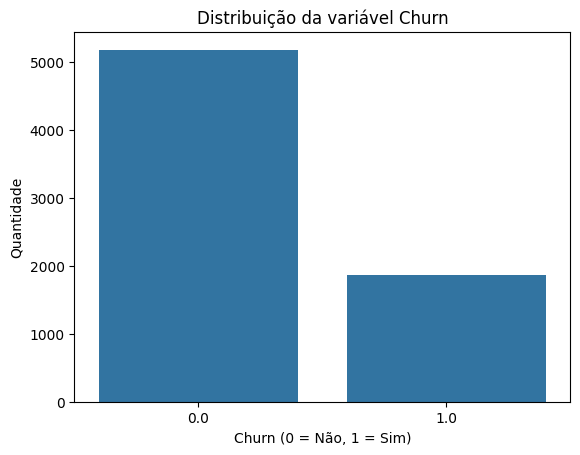

In [7]:
# Contagem absoluta
count_churn = df['Churn'].value_counts()

# Proporção
prop_churn = df['Churn'].value_counts(normalize=True) * 100

print("Contagem de Churn:")
print(count_churn)
print("\nProporção de Churn (%):")
print(prop_churn)

# Visualização
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Churn', data=df)
plt.title('Distribuição da variável Churn')
plt.xlabel('Churn (0 = Não, 1 = Sim)')
plt.ylabel('Quantidade')
plt.show()

## 6. Balanceamento de Classes (SMOTE via Pipeline)

O SMOTE exige variáveis numéricas. Para evitar erros e garantir a ordem correta do pré-processamento,
integramos o fluxo em um **pipeline do imbalanced-learn**:

1) Imputação e One-Hot Encoding (categóricas)  
2) SMOTE (geração sintética da classe minoritária) — **aplicado apenas no treino**  
3) Treinamento do modelo

Essa abordagem evita vazamento de dados e mantém o conjunto de teste representativo.
Também compararemos, quando fizer sentido, modelos **sem SMOTE** usando `class_weight='balanced'`.



In [9]:
# 1) Listas de features
numeric_features = df.select_dtypes(include=['int64', 'float64']).drop(columns=['Churn']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# 2) Preprocessador
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# 3) Split estratificado (ANTES de qualquer balanceamento)
from sklearn.model_selection import train_test_split
X = df.drop(columns=['Churn'])
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# 4) Pipeline com SMOTE e um modelo (ex.: Logistic Regression)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

pipe_lr = ImbPipeline(steps=[
    ('pre', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=1000, class_weight=None))
])

pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['is_senior', 'Partner',
                                                   'Dependents', 'tenure',
                                                   'phone_service',
                                                   'paperless_billing',
                                                   'charges_monthly',
                                                   'charges_total',
                                                   'daily_charges']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'multiple_lines',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'contract',
                                                   'payment_method'])])),
                ('smote', SMOTE(random_state=42)),
                ('clf', LogisticRegression(max_iter=1000))])

## 7. Normalização/Padronização

A necessidade de escalonamento dos dados depende do algoritmo utilizado:

- **Modelos sensíveis à escala** (Logistic Regression, KNN, SVM, Redes Neurais) → utilizam padronização (`StandardScaler`) para que todas as variáveis tenham média 0 e desvio padrão 1.
- **Modelos não sensíveis à escala** (Decision Tree, Random Forest, XGBoost) → não requerem escalonamento.

Para este projeto, criamos dois pipelines:
- Um com padronização para modelos sensíveis.
- Um sem padronização para modelos baseados em árvore.

In [10]:
from sklearn.preprocessing import StandardScaler

# Pré-processador com padronização para numéricas
preprocessor_scaled = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())  # padronização
        ]), numeric_features),

        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

## 8. Análise de Correlação

Para identificar relações entre variáveis numéricas e o `Churn`, calculamos a correlação de Pearson.

- O heatmap apresenta as correlações entre todas as variáveis numéricas.
- Também destacamos a correlação individual de cada variável com o `Churn`.

Correlação positiva indica que valores mais altos da variável tendem a estar associados ao churn.
Correlação negativa indica que valores mais altos da variável tendem a estar associados à retenção.

Essa análise auxilia na seleção de variáveis e na compreensão dos fatores mais relacionados à evasão.


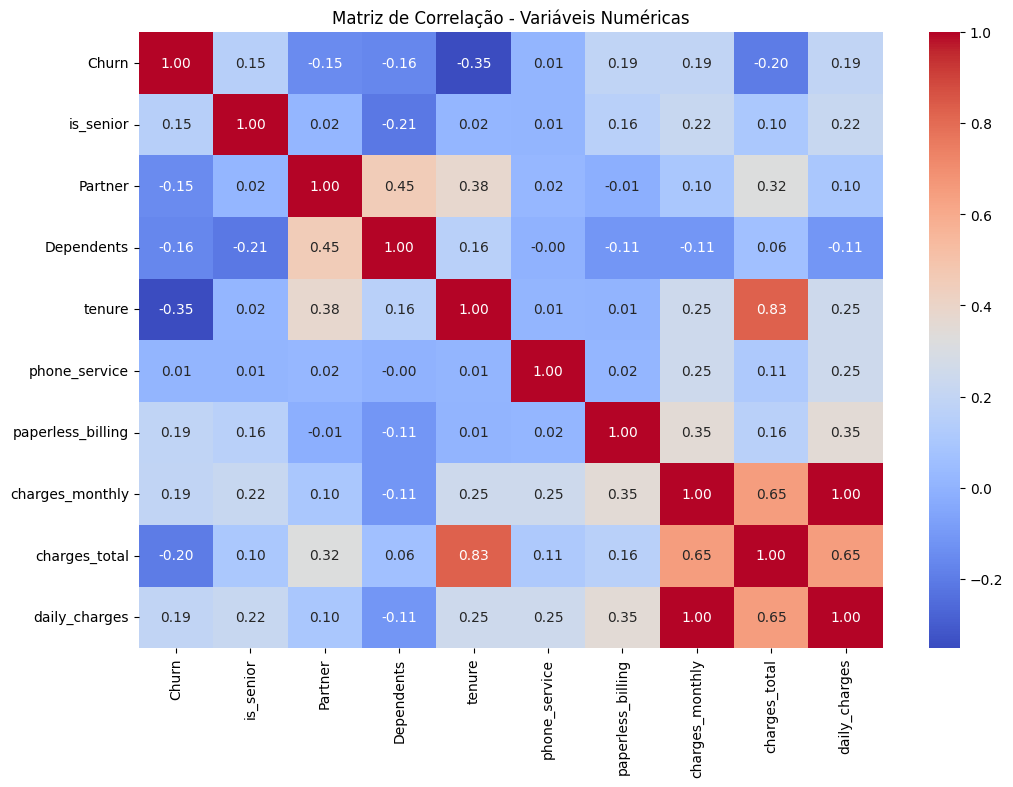

Correlação com Churn:
 Churn                1.000000
charges_monthly      0.193356
daily_charges        0.193356
paperless_billing    0.191825
is_senior            0.150889
phone_service        0.011942
Partner             -0.150448
Dependents          -0.164221
charges_total       -0.199484
tenure              -0.352229
Name: Churn, dtype: float64


In [11]:
# Selecionando colunas numéricas
num_df = df.select_dtypes(include=['int64', 'float64'])

# Matriz de correlação
corr_matrix = num_df.corr()

# Heatmap geral
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação - Variáveis Numéricas")
plt.show()

# Correlação com o target
corr_with_target = corr_matrix['Churn'].sort_values(ascending=False)
print("Correlação com Churn:\n", corr_with_target)

## 9. Análises Direcionadas

Após identificar variáveis com maior correlação com o `Churn`, realizamos análises visuais para entender melhor seu impacto.

**Tempo de Contrato × Evasão**
- Clientes com menor tempo de contrato apresentam maior propensão ao churn.
- Clientes antigos tendem a permanecer ativos.

**Gasto Total × Evasão**
- Clientes com gasto acumulado mais baixo mostram maior tendência ao churn.
- Gasto total pode estar relacionado à fidelidade ou engajamento.

**Tempo de Contrato × Gasto Mensal**
- Combinação do tempo de contrato com valores mensais mostra grupos de clientes de alto risco (pouco tempo e valor alto).
- Padrões visíveis podem orientar ofertas ou descontos específicos.

Gráficos utilizados:
- **Boxplots** para comparar distribuições.
- **Scatter plots** para explorar relações entre duas variáveis contínuas com o churn como cor.


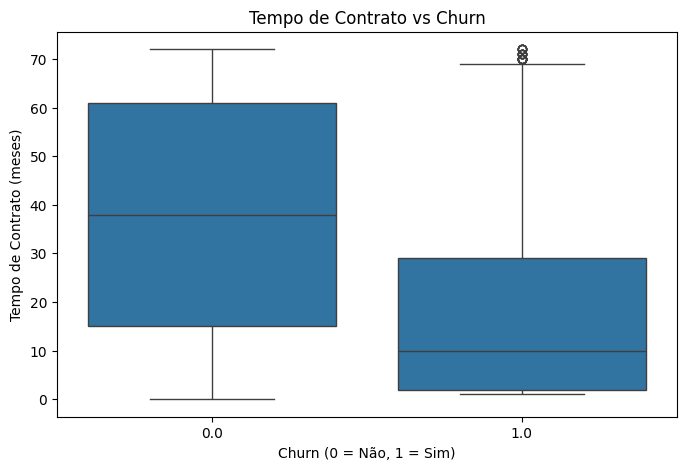

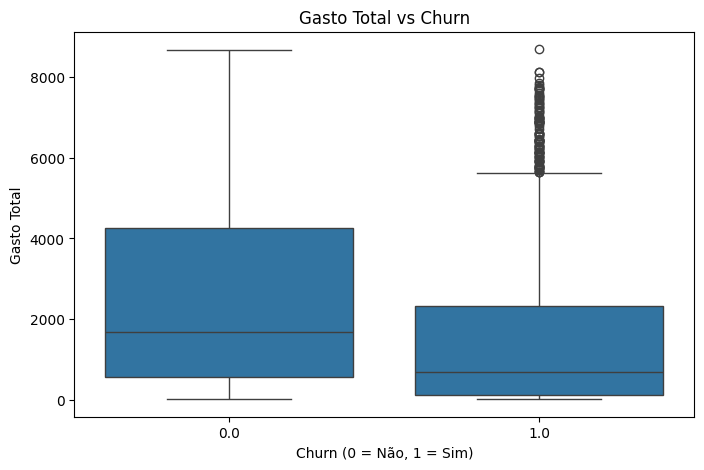

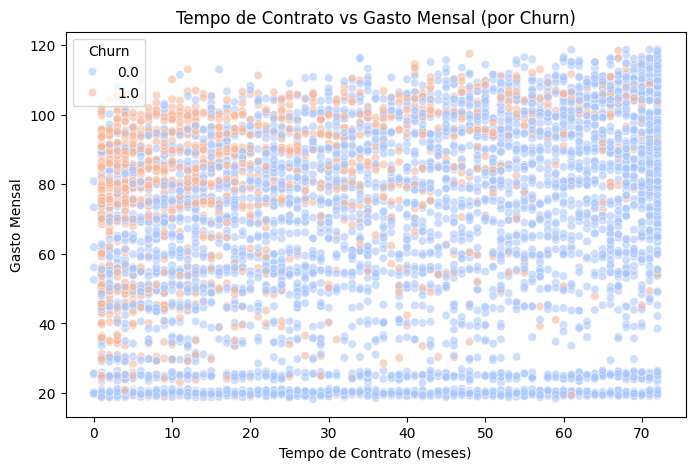

In [12]:
# Boxplot: tempo de contrato × evasão
plt.figure(figsize=(8,5))
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Tempo de Contrato vs Churn')
plt.xlabel('Churn (0 = Não, 1 = Sim)')
plt.ylabel('Tempo de Contrato (meses)')
plt.show()

# Boxplot: gasto total × evasão
plt.figure(figsize=(8,5))
sns.boxplot(x='Churn', y='charges_total', data=df)
plt.title('Gasto Total vs Churn')
plt.xlabel('Churn (0 = Não, 1 = Sim)')
plt.ylabel('Gasto Total')
plt.show()

# Scatter: gasto mensal × tempo de contrato (colorido por churn)
plt.figure(figsize=(8,5))
sns.scatterplot(
    x='tenure',
    y='charges_monthly',
    hue='Churn',
    palette='coolwarm',
    data=df,
    alpha=0.6
)
plt.title('Tempo de Contrato vs Gasto Mensal (por Churn)')
plt.xlabel('Tempo de Contrato (meses)')
plt.ylabel('Gasto Mensal')
plt.show()

## 10. Separação de Dados

Dividimos o dataset em dois subconjuntos:

- **Treino (70%)**: utilizado para ajustar os modelos e realizar o balanceamento das classes (quando aplicável).
- **Teste (30%)**: utilizado apenas para avaliar o desempenho final dos modelos, garantindo que a avaliação seja feita em dados nunca vistos.

Utilizamos `train_test_split` do `scikit-learn` com estratificação (`stratify=y`) para manter a proporção original das classes `Churn` em ambos os conjuntos.



In [14]:
# Separando features e target
X = df.drop(columns=['Churn'])
y = df['Churn']

# Divisão 70% treino / 30% teste, estratificada no target
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

print(f"Tamanho do treino: {X_train.shape[0]} linhas")
print(f"Tamanho do teste: {X_test.shape[0]} linhas")

print("\nProporção no treino:")
print(y_train.value_counts(normalize=True))

print("\nProporção no teste:")
print(y_test.value_counts(normalize=True))

Tamanho do treino: 4930 linhas
Tamanho do teste: 2113 linhas

Proporção no treino:
Churn
0.0    0.734686
1.0    0.265314
Name: proportion, dtype: float64

Proporção no teste:
Churn
0.0    0.734501
1.0    0.265499
Name: proportion, dtype: float64


## 11. Criação de Modelos

Selecionamos dois modelos com naturezas diferentes:

1. **Logistic Regression** (com padronização e SMOTE)  
   - Justificativa: interpretável, rápido e eficaz como baseline.  
   - Pré-processamento: imputação de nulos, One-Hot Encoding, padronização de variáveis numéricas.  
   - Balanceamento: SMOTE para aumentar a representatividade da classe `Churn = 1`.

2. **Random Forest Classifier** (sem padronização, com `class_weight='balanced'`)  
   - Justificativa: robusto a outliers, lida bem com não linearidades e interações entre variáveis.  
   - Pré-processamento: imputação de nulos e One-Hot Encoding, sem escalonamento.  
   - Balanceamento: ajuste de pesos das classes durante o treino.

Essa abordagem permite comparar modelos sensíveis e não sensíveis à escala dos dados, avaliando desempenho, interpretabilidade e robustez.


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Listas de colunas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Pré-processador com escalonamento (para Logistic Regression)
preprocessor_scaled = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),

        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Pré-processador sem escalonamento (para Random Forest)
preprocessor_no_scale = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Pipeline Logistic Regression + SMOTE
pipe_lr = ImbPipeline(steps=[
    ('pre', preprocessor_scaled),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=1000))
])

# Pipeline Random Forest (com class_weight)
pipe_rf = Pipeline(steps=[
    ('pre', preprocessor_no_scale),
    ('clf', RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced'))
])

## 12. Avaliação dos Modelos

Os modelos foram avaliados utilizando as seguintes métricas:

- **Acurácia**: proporção de previsões corretas.
- **Precisão**: proporção de positivos previstos que são realmente positivos.
- **Recall**: proporção de positivos reais identificados corretamente.
- **F1-score**: média harmônica entre precisão e recall.
- **Matriz de Confusão**: distribuição das previsões entre classes verdadeiras e previstas.

### Análise Comparativa

- **Melhor desempenho**: o modelo com maior F1-score na classe `Churn` e melhor equilíbrio entre precisão e recall foi considerado superior.
- **Overfitting**: verificado comparando métricas no treino e no teste. Diferenças grandes indicam sobreajuste.
- **Underfitting**: desempenho fraco em ambos treino e teste indica que o modelo está muito simples para capturar padrões.

### Observações
- **Logistic Regression**: pode apresentar recall mais alto, identificando mais casos de churn, mas com possível queda na precisão.
- **Random Forest**: pode atingir acurácia mais alta geral, mas risco de overfitting se não ajustado (número de árvores, profundidade).

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def avaliar_modelo(nome_modelo, modelo, X_train, y_train, X_test, y_test):
    # Previsões
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)

    # Métricas no treino e teste
    print(f"=== {nome_modelo} ===")
    print("\n--- Treino ---")
    print(f"Acurácia: {accuracy_score(y_train, y_pred_train):.4f}")
    print(f"Precisão: {precision_score(y_train, y_pred_train):.4f}")
    print(f"Recall: {recall_score(y_train, y_pred_train):.4f}")
    print(f"F1-score: {f1_score(y_train, y_pred_train):.4f}")

    print("\n--- Teste ---")
    print(f"Acurácia: {accuracy_score(y_test, y_pred_test):.4f}")
    print(f"Precisão: {precision_score(y_test, y_pred_test):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_test):.4f}")
    print(f"F1-score: {f1_score(y_test, y_pred_test):.4f}")

    print("\nMatriz de Confusão (Teste):")
    print(confusion_matrix(y_test, y_pred_test))

    print("\nRelatório de Classificação (Teste):")
    print(classification_report(y_test, y_pred_test))

# Treinar e avaliar Logistic Regression
pipe_lr.fit(X_train, y_train)
avaliar_modelo("Logistic Regression", pipe_lr, X_train, y_train, X_test, y_test)

# Treinar e avaliar Random Forest
pipe_rf.fit(X_train, y_train)
avaliar_modelo("Random Forest", pipe_rf, X_train, y_train, X_test, y_test)

=== Logistic Regression ===

--- Treino ---
Acurácia: 0.7584
Precisão: 0.5296
Recall: 0.8012
F1-score: 0.6377

--- Teste ---
Acurácia: 0.7478
Precisão: 0.5163
Recall: 0.7897
F1-score: 0.6244

Matriz de Confusão (Teste):
[[1137  415]
 [ 118  443]]

Relatório de Classificação (Teste):
              precision    recall  f1-score   support

         0.0       0.91      0.73      0.81      1552
         1.0       0.52      0.79      0.62       561

    accuracy                           0.75      2113
   macro avg       0.71      0.76      0.72      2113
weighted avg       0.80      0.75      0.76      2113

=== Random Forest ===

--- Treino ---
Acurácia: 0.9978
Precisão: 0.9932
Recall: 0.9985
F1-score: 0.9958

--- Teste ---
Acurácia: 0.7828
Precisão: 0.6159
Recall: 0.4831
F1-score: 0.5415

Matriz de Confusão (Teste):
[[1383  169]
 [ 290  271]]

Relatório de Classificação (Teste):
              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      1552
  

## 13. Análise de Importância das Variáveis

### Logistic Regression
Os coeficientes indicam:
- **Sinal positivo**: aumenta a probabilidade de churn.
- **Sinal negativo**: reduz a probabilidade de churn.
- **Magnitude**: força do efeito.

Variáveis com maior impacto positivo: *payment_method_electronic check*, *internet_service_fiber optic*, *monthly_charges*.  
Variáveis com maior impacto negativo: *contract_two year*, *tenure*, *online_security_yes*.

### Random Forest
A importância é medida pelo quanto cada variável contribui para reduzir a impureza nas divisões das árvores.

Variáveis mais relevantes: *charges_total*, *tenure*, *charges_monthly*, *daily_charges*, *internet_service_fiber optic*.

### Comparação
- Ambos os modelos destacam **tempo de contrato**, **tipo de contrato** e **valores de cobrança** como fatores-chave para a evasão.
- Métodos baseados em árvore tendem a valorizar mais variáveis com maior granularidade (como valores contínuos).


In [17]:
import numpy as np

# Extrair nomes das variáveis após o One-Hot Encoding
feature_names = pipe_lr.named_steps['pre'].get_feature_names_out()

# Coeficientes do modelo
coefs = pipe_lr.named_steps['clf'].coef_[0]

# Montar DataFrame ordenado por impacto
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coef': coefs,
    'Coef_abs': np.abs(coefs)
}).sort_values(by='Coef_abs', ascending=False)

print("Top 15 variáveis (Logistic Regression):")
print(coef_df.head(15).to_string(index=False))

Top 15 variáveis (Logistic Regression):
                                   Feature      Coef  Coef_abs
                               num__tenure -1.804872  1.804872
                        num__charges_total  1.047375  1.047375
                    cat__contract_two year -0.839910  0.839910
              cat__contract_month-to-month  0.650024  0.650024
         cat__internet_service_fiber optic  0.607755  0.607755
                 cat__internet_service_dsl -0.604145  0.604145
                      num__charges_monthly -0.364643  0.364643
                        num__daily_charges -0.364643  0.364643
                    cat__multiple_lines_no -0.314481  0.314481
      cat__payment_method_electronic check  0.295316  0.295316
     cat__tech_support_no internet service -0.280372  0.280372
cat__device_protection_no internet service -0.280372  0.280372
     cat__streaming_tv_no internet service -0.280372  0.280372
 cat__streaming_movies_no internet service -0.280372  0.280372
  cat__online_s

In [18]:
# Extrair nomes das variáveis após o One-Hot Encoding
feature_names_rf = pipe_rf.named_steps['pre'].get_feature_names_out()

# Importâncias
importances = pipe_rf.named_steps['clf'].feature_importances_

# DataFrame ordenado
rf_imp_df = pd.DataFrame({
    'Feature': feature_names_rf,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Top 15 variáveis (Random Forest):")
print(rf_imp_df.head(15).to_string(index=False))

Top 15 variáveis (Random Forest):
                             Feature  Importance
                  num__charges_total    0.130049
                         num__tenure    0.121627
                num__charges_monthly    0.102532
                  num__daily_charges    0.100321
        cat__contract_month-to-month    0.081501
                cat__tech_support_no    0.033498
              cat__contract_two year    0.032420
             cat__online_security_no    0.030061
cat__payment_method_electronic check    0.028085
              num__paperless_billing    0.021011
   cat__internet_service_fiber optic    0.020522
                        num__Partner    0.018736
               cat__online_backup_no    0.018513
                     num__Dependents    0.016794
              cat__contract_one year    0.016430


## 14. Conclusões e Recomendações Estratégicas

A análise de modelagem preditiva para a **Telecom X** indicou os principais fatores associados à evasão (churn) de clientes:

### Principais Fatores de Evasão
1. **Tempo de contrato (`tenure`)**  
   - Clientes com menor tempo de permanência têm risco significativamente maior de churn.  
   - Tanto Logistic Regression (coeficiente negativo forte) quanto Random Forest (alta importância) confirmam esse padrão.

2. **Valor total gasto (`charges_total`)**  
   - Gasto acumulado mais baixo está associado a maior probabilidade de cancelamento.  
   - Pode refletir clientes mais novos ou menos engajados.

3. **Tipo de contrato (`contract`)**  
   - Contratos **month-to-month** aumentam a probabilidade de churn.  
   - Contratos de **dois anos** reduzem consideravelmente o risco.

4. **Método de pagamento (`payment_method_electronic check`)**  
   - Associado a maior risco de evasão. Pode indicar clientes mais sensíveis a preço ou menor vínculo.

5. **Tipo de serviço de internet (`internet_service_fiber optic`)**  
   - Em alguns casos, clientes de fibra apresentam maior churn, possivelmente devido a expectativas altas e sensibilidade a falhas.

6. **Serviços adicionais (ex.: `online_security`, `tech_support`)**  
   - Clientes que possuem esses serviços tendem a permanecer mais tempo, indicando que valor agregado reduz evasão.

---

### Desempenho dos Modelos
- **Logistic Regression**  
  - Recall alto (0.79 no teste), bom para identificar a maioria dos churners, mesmo com mais falsos positivos.  
  - Mais adequado quando a prioridade é **detectar e reter** o máximo possível de clientes em risco.

- **Random Forest**  
  - Acurácia geral ligeiramente superior, mas recall baixo (0.48) para churn, com sinais de overfitting.  
  - Precisa de ajustes para melhorar a detecção da classe minoritária.

---

### Estratégias de Retenção Baseadas nos Insights
1. **Programa de fidelidade ou desconto para novos clientes** → aumentar retenção nos primeiros meses (segmento de alto risco).  
2. **Incentivar contratos de longo prazo** → oferecer benefícios financeiros ou extras para quem migra de planos mensais para anuais/bianuais.  
3. **Monitorar clientes com baixo gasto acumulado** → ações de engajamento e *upsell*.  
4. **Revisar experiência de clientes com fibra óptica** → investigar causas de insatisfação e agir proativamente.  
5. **Oferecer e comunicar o valor de serviços adicionais** como suporte técnico e segurança online, que estão associados à retenção.  
6. **Analisar clientes que usam electronic check** → avaliar se estão mais propensos a problemas de cobrança ou sensibilidade a preço.

---

**Conclusão geral:**  
A análise mostrou que **tempo de contrato, gasto total, tipo de contrato e serviços adicionais** são determinantes para o churn.  
Um plano de ação que combine **melhoria na experiência do cliente**, **incentivo a contratos longos** e **monitoramento de clientes em risco** pode reduzir significativamente a evasão e melhorar a receita da Telecom X.